In [93]:
import sys
sys.path.append ('../../')
from pathlib import Path
import json
import pdb
import collections
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import tqdm
import math
import random as rand
from PIL import Image
from collections import defaultdict
path = Path()
import pytesseract
from pytesseract import Output
pytesseract.pytesseract.tesseract_cmd = '/usr/local/Cellar/tesseract/4.1.1/bin/tesseract'
path = Path()
import copy

# Reading raw annots with processed image title

In [149]:
ANNOT = "json/COCOUI5.json"
JPGS = path/'processed_images'

In [150]:
tot_annot = json.load((path/ANNOT).open())

In [151]:
tot_annot[0]['filename']

'0.png'

In [651]:
#Filter out annotations, only keep ones where we have images
tot_annot_good = []
for annot in tot_annot:
    if os.path.isfile(JPGS / convert_filename(annot) ):
        tot_annot_good.append(annot)
len(tot_annot_good)

35064

In [126]:
!ls ../scraper/tutorial/resources
urls = json.load((path/"../scraper/tutorial/resources/all_new_urls_1.json").open())

all_new_urls_1.json


# Constants New and Improved

In [559]:
def get_cats():
    cats = {1: "buttons", 2: "input", 3: "select", 4: "big heading", 
            5: "paragraphs", 6:"checkbox", 7: "above input", 8: "a", 9: "image", 10: "form",
           11: "legend", 12: "field", 13: "lists", 14: "list element", 15: "div", 16: "small heading",
           17: "button type", 18: "text type", 19: "input type", 20: "select type", 22: "image type", 21: "checkbox type"}
    return cats

def get_cats_to_super():
    cats_to_super = {11: 2, 10:3}
    return cats_to_super

def get_preserve_cats():
    preserve_cats = [2,3,6]
    return preserve_cats

def get_super_cats():
    super_cats = {1: "button type", 2: "text type", 3: "input type"}
    return super_cats

def get_banned_cats():
    banned_cats = [10, 12, 13, 15]
    return banned_cats

def get_cats_reverse():
    cats_reverse = {v: k for k,v in cats.items()}
    return cats_reverse

def get_used_cats():
    used_cats = [str(k) for k in cats.keys()]
    return used_cats

def get_padding():
    PADDING = {k: 10 for k in cats.keys()}
    #for i in [4,5,7,16,18]: PADDING[i] = 10
    for i in [2, 3, 6, 19, 20, 21]: PADDING[i] = 0
    return PADDING

# Visualization

In [560]:
def convert_filename(annot):
    fname = "page_" + annot['filename'].split(".")[0] + ".jpeg"
    return fname

In [561]:
def draw(idx=None):
    if idx is None:
        idx = rand.randint(0, len(tot_annot)-1)
        print(idx)
    draw_idx(open_image(JPGS / convert_filename(tot_annot[idx])), process_image(copy.deepcopy(tot_annot[idx]))['entities'])

In [659]:
def draw_before_after(idx=None):
    if idx is None:
        idx = rand.randint(0, len(tot_annot)-1)
        print(idx)
    draw_idx(open_image(JPGS / convert_filename(tot_annot_good[idx])), process_image(copy.deepcopy(tot_annot[idx]), do_filter=False)['entities'])
    draw_idx(open_image(JPGS / convert_filename(tot_annot_good[idx])), process_image(copy.deepcopy(tot_annot[idx]))['entities'])

In [563]:
def get_url(idx): return urls[tot_annot[idx]['page_id']]

# Master Processing Function

In [564]:
def process_image(annot, do_filter=True):
    annot_ents = annot['entities']
    idx = open_image(JPGS / convert_filename(annot))
    
    ents = []
    
    #get all bounding box coordinates in a nice format off of scraped data annotations
    for class_idx,coord_list in annot_ents.items():
        if len(coord_list) <= 0: continue
        if len(coord_list['coords']) > 0:
            for coord in coord_list['coords']:
                if type(coord) != dict: continue
                bb = get_bb(coord)
                if bb[0] > 768 or bb[1] > 1024 or get_box_size(bb) <= 0: 
                    continue
                tampered = False
                if bb[0] < 0: 
                    tampered = True
                    bb[0] = 0
                if bb[1] < 0:
                    tampered = True
                    bb[1] = 0
                if bb[2] < 0: 
                    tampered = True
                    bb[2] = 0
                if bb[3] < 0: 
                    tampered = True
                    bb[3] = 0
                if bb[2] > 768: 
                    tampered = True
                    bb[2] = 1024
                if bb[3] > 1024: 
                    tampered = True
                    bb[3] = 768
                if tampered == True: continue
                ents.append((bb,int(class_idx)))
     
    #if we don't want to filter on our pipeline
    if not do_filter: 
        annot['entities'] = ents
        return annot
    
    filtered_ents = []
    
    
    #do individual class filters
    for ent in ents:
        
        colors = get_colors_of_bb(idx, ent, False)
        color_sum = 0
        for col in colors:
            color_sum += col[0]
        #print("{} {}".format(len(colors), colors[0][0] / color_sum))
        if ent[1] not in get_preserve_cats():
            if colors[0][0] / color_sum >= 0.98: continue
            if len(colors) < 2: continue
        
        size = get_box_size(ent[0])
        
        if size > 500000: continue
        
        if ent[1] == get_cats_reverse()['list element']:
            filt = filter_li_bound(idx, ent)
            
            if len(filt) > 0:
                filtered_ents.append(filt)
                
        elif ent[1] == get_cats_reverse()["a"]:
            filt = filter_a_bound(idx,ent)
            
            if len(filt) > 0:
                filtered_ents.append(filt)
        
        elif ent[1] == get_cats_reverse()["above input"]:
            filt = filter_above_input_bound(idx, ent)
            
            if len(filt) > 0:
                filtered_ents.append(filt)
                
        elif ent[1] == get_cats_reverse()['select']:
            filtered_ents.append(filter_select(idx, ent))
            
        elif ent[1] == get_cats_reverse()['input']:
            filt = filter_input(idx, ent)
            
            if len(filt) > 0:
                filtered_ents.append(filt)
        
        elif ent[1] == get_cats_reverse()['big heading'] or ent[1] == get_cats_reverse()['small heading'] or ent[1] == get_cats_reverse()['paragraphs']:
            filt = filter_text(idx, ent)
            
            if len(filt) > 0:
                filtered_ents.append(filt)
        
        elif ent[1] == get_cats_reverse()['checkbox']:
            filtered_ents.append([ent[0][0], ent[0][1], ent[0][2], ent[0][3], get_cats_reverse()['checkbox type']])
        
        elif ent[1] == get_cats_reverse()['image']:
            filtered_ents.append([ent[0][0], ent[0][1], ent[0][2], ent[0][3], get_cats_reverse()['image type']])
                
        elif ent[1] in get_banned_cats():
            continue
        
        elif ent[1] == get_cats_reverse()['buttons']:

            filtered_ents.append(filter_button(idx,ent))
            
        else:
            filtered_ents.append([ent[0][0], ent[0][1], ent[0][2], ent[0][3], ent[1]])

    #do individual filters on processed filters, essenetially a second pass over the first ie. tighten text
    filtered_ents = filter_filtered(idx, filtered_ents)

    #combine different class filters ie. NMS, priority overlap
    final_values = post_filter(idx, filtered_ents)
    
    annot['entities'] = final_values

    #return the final annotation ready for training
    return annot
    
    
    

# Post Filtering  

In [565]:
def post_filter(idx, ents):
    filtered_ents = []
    
    for eid, ent in enumerate(ents):
        
        if ent[4] == get_cats_reverse()['image type']:
            
            overlap = False
            for e2id, e2 in enumerate(ents):
                if e2id != eid:
                    if bb_overlap(get_bb_no_cls(ent), get_bb_no_cls(e2)):
                        overlap = True
                        break
                        
            if not overlap:
                filtered_ents.extend(post_image_filter(idx, ent))
            else:
                filtered_ents.append(ent)
        
        else:
            filtered_ents.append(ent)

    after_dropdown = filter_phantom_dropdowns(filtered_ents)
    
    after_tighten = tighten_text_filter(idx, after_dropdown)
    
    return non_max_suppression_fast(after_tighten, 0.01)

In [566]:
def post_image_filter(idx, bound):
    otop, oleft = bound[0], bound[1]
    info = get_text_on_bb(idx, bound, see_results=False)

    ents = []
    
    pad = get_padding()[bound[4]]
    
    for idx,box in enumerate(info['text']):
        if box.replace(" ", "") != "":
            bb = [info['top'][idx]+otop-pad, info['left'][idx]+oleft-pad, info['top'][idx]+info['height'][idx]+otop-pad, oleft+-pad+info['left'][idx]+info['width'][idx]]
            if get_box_size(bb) < 100: continue
            bb.extend([get_cats_reverse()['text type'], info])
            ents.append(bb)
    
    if len(ents) > 0:
        return ents
    else:
        return [bound]
    

In [567]:
def tighten_text_filter(idx, ents):

    filtered_ents = []
    
    for ent in ents:
        if ent[4] == get_cats_reverse()['text type']:
            filtered_ents.append(tighten_text_bb(idx, ent))
        else:
            filtered_ents.append(ent)
    
    return filtered_ents

In [616]:
def tighten_text_bb(idx, bound):

    otop, oleft, obot, oright, info = bound[0], bound[1], bound[2], bound[3], bound[-1]
    
    if type(info) == int:
        info = get_text_on_bb(idx, bound, see_results=False)
    else:
        bound = bound[:-1]
    
    ents = []
    left, top, width, height = math.inf, math.inf, -math.inf, -math.inf
    
    has_word = False
    
    for idx,box in enumerate(info['text']):

        bb = [info['top'][idx], info['left'][idx], info['top'][idx]+info['height'][idx], info['left'][idx]+info['width'][idx]]
        if box.replace(" ", "") == "": 
            continue

        has_word = True
        left = min(left, bb[1])
        top = min(top, bb[0])
        width = max(width, bb[3])
        height = max(height, bb[2])
    
    if has_word:
        final_box = [otop+top-get_padding()[get_cats_reverse()['text type']], oleft+left-get_padding()[get_cats_reverse()['text type']], otop-get_padding()[get_cats_reverse()['text type']]+height, oleft-get_padding()[get_cats_reverse()['text type']]+width, get_cats_reverse()['text type']]
        #print(final_box-
        #print(bound[0])
        return final_box
    else:
        return bound

In [569]:
def vert_overlap(bb1, bb2):
    return not (bb1[2] < bb2[0] or bb2[2] < bb1[1])

def hor_overlap(bb1, bb2):
    return not (bb1[3] < bb2[1] or bb2[3] < bb1[1])
    
def bb_overlap(bb1, bb2):
    return vert_overlap(bb1, bb2) and hor_overlap(bb1, bb2)

def get_bb_no_cls(ent):
    return ent[:-1]

In [570]:
def rel_vert_overlap(e1, e2):
    vert_overlap = min(e1[3], e2[3]) - max(e1[1], e2[1])
    
    return vert_overlap / (max(e1[3]-e1[1], e2[3]-e2[1]))

In [ ]:
def filter_phantom_dropdowns(ents):
    button_ents = []
    filtered_ents = []
    
    for ent in ents:
        if ent[4] == get_cats_reverse()['button type']:
            if len(ent) > 5 and ent[5] == 0:
                button_ents.append(ent)
            else:
                filtered_ents.append(ent)
        else:
            filtered_ents.append(ent)

    for e1 in button_ents:
        num_over = 0
        for e2 in button_ents:
            if (e1 == e2): continue
            vo = rel_vert_overlap(e1, e1)
            
            if vo > 0.9: num_over += 1
        
        if num_over <= 3:
            filtered_ents.append(e1)

    return filtered_ents

In [572]:
def filter_filtered(idx, ents):

    filtered_ents = []
    
    for ent in ents:
        if ent[4] == get_cats_reverse()['text type']:
            filtered_ents.append(tighten_text_bb(idx, ent))
        else:
            filtered_ents.append(ent)
    
    return filtered_ents

# Special NMS

In [ ]:
no_combine = [get_cats_reverse()['button type'], get_cats_reverse()['input type'], get_cats_reverse()['select type'], get_cats_reverse()['checkbox type']]
prior = {get_cats_reverse()['button type']: 5, get_cats_reverse()['text type']: 5, get_cats_reverse()['input type']: 6,
         get_cats_reverse()['select type']: 6, get_cats_reverse()['image type']: 1, get_cats_reverse()['checkbox type']: 7}

In [573]:
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    for box in boxes:
        if len(box) == 5:
            box.append(0)
    boxes = np.array(boxes)
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	abs
    pick = []
    # grab the coordinates of the bounding boxes

    x1 = boxes[:,1]
    y1 = boxes[:,0]
    x2 = boxes[:,3]
    y2 = boxes[:,2]
    cls = boxes[:,4]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    num_orig_boxes = len(x1)
    
    new_idx_num = len(x1)
    
    new_idxs = []
    

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        
        #append new combined boxes to list of candidate boxes for comparison
        if len(new_idxs) > 0:
            used_idxs = np.append(idxs,new_idxs).astype("int")
        else: 
            used_idxs = idxs.astype("int")

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[used_idxs])-5
        yy1 = np.maximum(y1[i], y1[used_idxs])-5
        xx2 = np.minimum(x2[i], x2[used_idxs])+5
        yy2 = np.minimum(y2[i], y2[used_idxs])+5
        
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        # compute the ratio of overlap
        overlap = (w * h) / area[used_idxs]
        overlap[last] = 0
        
        #solve overlap for box in question with all overlapping boxes
        picks,delete = solveOverlap(np.concatenate(([last], np.where(overlap > 0)[0]), 0), np.concatenate(([boxes[used_idxs[last]]], boxes[used_idxs[np.where(overlap > 0)[0]]])))

        try:
            #add new boxes
            new_idxs = np.append(new_idxs, [n for n in range(new_idx_num, len(picks[0])+new_idx_num)])
            if len(picks[0]) > 0:
                x1 = np.append(x1, picks[0])
                x2 = np.append(x2, picks[1])
                y1 = np.append(y1, picks[2])
                y2 = np.append(y2, picks[3])
                cls = np.append(cls, picks[4])
                boxes = np.concatenate((boxes, np.array(picks[5])), 0)
        except:
            pdb.set_trace()

        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        new_idx_num += len(picks[0])
        
        #delete boxes, append newly created boxes to candidate list
        new_idxs_delete = []
        for del_id in delete:
            del_id = del_id - len(idxs)
            if del_id > 0:
                new_idxs_delete.append(del_id)
        new_idxs = np.delete(new_idxs, new_idxs_delete)
        
        idxs = np.delete(idxs, delete)

    return boxes[new_idxs.astype("int")]

In [ ]:
def overlap(b1, b2):
    return max(0,min(b1[2], b2[2])-max(b1[0], b2[0]))*max(0,min(b1[3], b2[3])-max(b1[1], b2[1])) / ((b1[3]-b1[1])*(b1[2]-b1[0]))
    
    
def solveOverlap(idxs, boxes):
    if len(idxs) == 1:
        boxes = boxes[0]
        return [[boxes[0]], [boxes[1]], [boxes[2]], [boxes[3]], [boxes[4]], [boxes.tolist()]], idxs

    classes = defaultdict(list)
    cls_boxes = []
    
    for box in boxes:
        classes[box[4]].append(box)
    
    newx1, newx2, newy1, newy2, newcls = [],[],[],[],[]
    
    for cls, box in classes.items():
        if cls in no_combine:
            for bo in box:
                include = True
                for obo in box:
                    if (bo == obo).all(): continue
                    else:
                        if overlap(bo, obo) > 0.95:
                            include = False
                            break
                if include: cls_boxes.append(bo)
        else:
                
            minx, miny, maxx, maxy, wc = math.inf, math.inf, -math.inf, -math.inf, 0

            for bo in box:
                miny = min(bo[0], miny)
                minx = min(bo[1], minx)
                maxx = max(bo[3], maxx)
                maxy = max(bo[2], maxy)
                wc = wc + bo[5]
                """
                if minx == math.inf or bb_overlap(bo, [miny-5,minx-5,maxy+5,maxx+5]):
                    miny = min(bo[0], miny)
                    minx = min(bo[1], minx)
                    maxx = max(bo[3], maxx)
                    maxy = max(bo[2], maxy)
                else:
                    cls_boxes.append(bo)
                """

            cls_boxes.append([miny, minx, maxy, maxx, cls, wc])
    
    ret_boxes = []

    for box in cls_boxes:
        remove_box = False
        for obox in cls_boxes:
            if box[4] == obox[4]: continue
            
            #print("CURR BOX: {}, NEW BOX: {}".format(get_box_size(box), get_box_size(obox)))
            try:
                if prior[box[4]] > prior[obox[4]]: 
                    continue
                elif prior[box[4]] < prior[obox[4]] and overlap(box, obox) > 0.3:
                    #print("LAP: {}, BOX: {}, OBOX: {}".format(overlap(box, obox)))
                    remove_box = True
                    break
                else:
                    if get_box_size(box) < get_box_size(obox) and overlap(box, obox) > 0.3:
                        #print("LAP: {}, BOX: {}, OBOX: {}".format(overlap(box, obox)))
                        remove_box = True
            except:
                pdb.set_trace()
                    
        if not remove_box:
            ret_boxes.append(box)
            newx1.append(box[1])
            newx2.append(box[3])
            newy1.append(box[0])
            newy2.append(box[2])
            newcls.append(box[4])
            
    #pdb.set_trace()
    return [newx1, newx2, newy1, newy2, newcls, ret_boxes], idxs

# Class Filters 

In [574]:
def filter_a_bound(idx, a_bound):
    num_words,info = get_num_words(idx, a_bound, see_results=False)
    
    size = get_box_size(a_bound[0])
    
    if num_words <= 3:
        return [a_bound[0][0], a_bound[0][1], a_bound[0][2], a_bound[0][3], get_cats_reverse()["button type"], num_words]
    else:
        return [a_bound[0][0], a_bound[0][1], a_bound[0][2], a_bound[0][3], get_cats_reverse()["text type"], info]

In [575]:
def filter_divs(idx, d_bound):
    wc,info,words = get_num_words(idx, d_bound, see_results=False, return_words=True)

    if wc > 0:
        return [d_bound[0][0], d_bound[0][1], d_bound[0][2], d_bound[0][3], get_cats_reverse()['text type'], info]
    else:
        return []

In [576]:
def filter_text(idx, h_bound):
    wc,info,words = get_num_words(idx, h_bound, see_results=False, return_words=True)

    if wc > 0:
        return [h_bound[0][0], h_bound[0][1], h_bound[0][2], h_bound[0][3], get_cats_reverse()['text type'],info]
    else:
        return []

In [577]:
def filter_button(idx, b_bound):
    return [b_bound[0][0], b_bound[0][1], b_bound[0][2], b_bound[0][3], get_cats_reverse()['button type']]

In [578]:
def filter_input(idx, i_bound):
    return [i_bound[0][0], i_bound[0][1], i_bound[0][2], i_bound[0][3], get_cats_reverse()['input type']]

In [579]:
def filter_select(idx, s_bound):
    return [s_bound[0][0], s_bound[0][1], s_bound[0][2], s_bound[0][3], get_cats_reverse()['select type']]

In [580]:
# If too small discard (300), else if search keyword found then label as element, else text
def filter_above_input_bound(idx, ai_bound):
    size = get_box_size(ai_bound[0])
    
    if size < 500:
        return []
    
    wc,info,words = get_num_words(idx, ai_bound, see_results=False, return_words=True)
    
    if "Search" in words or "search" in words or "http" in words:
        return [ai_bound[0][0], ai_bound[0][1], ai_bound[0][2], ai_bound[0][3], get_cats_reverse()["input type"]]
    else:
        return [ai_bound[0][0], ai_bound[0][1], ai_bound[0][2], ai_bound[0][3], get_cats_reverse()["text type"], info]
    

In [581]:
def filter_li_bound(idx, li_bound):
    num_words,info = get_num_words(idx, li_bound, see_results=False)
    
    if num_words < 3:
        return [li_bound[0][0], li_bound[0][1], li_bound[0][2], li_bound[0][3], get_cats_reverse()["button type"], num_words]
    else:
        return [li_bound[0][0], li_bound[0][1], li_bound[0][2], li_bound[0][3], get_cats_reverse()["text type"],info]

def draw_list_element_with_filter(idx):
    return draw_idx(idx, cls=get_cats_reverse()["list element"], with_filter=True)

def draw_random_list_elements():
    return draw_certain_class(get_cats_reverse()['list element'])

# Helper Functions

In [582]:
def draw_text_bb(im_idx):
    info = get_text_info(idx=im_idx)
    
    ents = []
    
    for idx,box in enumerate(info['text']):
        bb = [info['top'][idx], info['left'][idx], info['top'][idx]+info['height'][idx], info['left'][idx]+info['width'][idx]]
        ents.append([bb,get_cats_reverse()['text type']])

    draw_idx(im_idx, ents=ents, cls=get_cats_reverse()['text type'])

In [583]:
def get_bb(coords): 
    try:
        ret = np.array([coords['top'], coords['left'], coords['bottom'], coords['right']])
    except:
        pdb.set_trace()
    return ret

In [584]:
def process_ents(ents):
    new_ents = []
    for class_idx, coord_list in ents.items():
        if len(coord_list) <= 0: continue
        if len(coord_list['coords']) > 0:
            for coord in coord_list['coords']:
                bb = get_bb(coord)
                if bb[0] > 768 or bb[1] > 1024 or get_box_size(bb) <= 0: 
                    print("cls: {} box: {}, bs: {}".format(class_idx, bb, get_box_size(bb)))
                    continue
                new_ents.append((bb,int(class_idx)))
    return new_ents

In [585]:
def open_image(fn):
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    im = cv2.imread(str(fn), flags).astype(np.float32)/255
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [586]:
def hw_bb(bb):
    return np.array([ bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1 ])

In [587]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return ax

In [588]:
def draw_outline(o, lw):
    o.set_path_effects( [patheffects.Stroke(linewidth=lw, foreground='black'),
                          patheffects.Normal()] )

In [589]:
def draw_rect(ax, b, color='red'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [590]:
def draw_text(ax, xy, txt, sz=6, color='white'):
    text = ax.text(*xy, txt, verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [591]:
def bb_hw(a):
    return np.array( [ a[1], a[0], a[3] - a[1] + 1, a[2] - a[0] + 1 ] )

In [592]:
def draw_im(im, ann, cls=None, with_banned=False):
    # im is image, ann is annotations
    ax = show_img(im, figsize=(16, 8))
    for box in ann:
        if len(box) >= 5:
            b = box[:4]
            c = box[4]
        else:
            b = box[0]
            c = box[1]
        if not with_banned:
            if c in get_banned_cats(): continue
        # b is bbox, c is class id
        b = bb_hw(b)
        if cls is None or c == cls:
            draw_rect(ax, b)
            titl = get_cats()[c] + " " + str(box[5]) if len(box) > 5 else get_cats()[c]
            draw_text(ax, b[:2], titl, sz=6)

In [593]:
def draw_img(idx):
    show_img(idx, figsize=(10,20))

In [594]:
def get_random_annotation_idx():
    idx = rand.randint(0,len(trn_annot_indexes))
    idx = trn_annot_indexes[idx]
    return idx

In [595]:
def draw_certain_class(cls, with_banned=False, with_filter=False):
    found = False
    while found is False:
        idx = get_random_annotation_idx()
        for el in trn_anno[idx]:
            if el[1] == cls:
                found = True
                break
    draw_idx(idx, cls=cls, with_filter=with_filter, with_banned=with_banned)
    return idx

In [596]:
def get_crop(idx, ent, see_results=True, padding=None):
    img = idx
    if len(ent) == 2:
        bb = ent[0]
        padding = get_padding()[ent[1]] if padding is None else padding
    else:
        bb = ent
        padding = get_padding()[get_cats_reverse()['text type']] if padding is None else padding
    
    im = img[max(0,int(bb[0])-padding):min(1024,padding+int(bb[2])), max(0,int(bb[1])-padding):min(1024,padding+int(bb[3]))]
    
    if see_results:
        ax = show_img(im)
    
        draw_rect(ax, bb_hw([0,0,bb[2]-bb[0]+2*padding, bb[3]-bb[1]+2*padding]))
    
    return im

In [597]:
def draw_idx(idx, ents=None, cls=None, with_filter=False, with_banned=False):
    if ents is None: 
        ents = trn_anno[idx] # training annotations
    
    if with_filter: 
        ents = filter_ents(idx, ents, cls)
        cls = None

    im = idx # trn_fns is training image file names
    draw_im(im, ents, cls, with_banned) # im_a is an element of annotation

In [598]:
def draw_random_idx(with_filter=False):
    idx = get_random_annotation_idx()
    draw_idx(idx, with_filter=with_filter)
    return idx

In [599]:
def draw_before_after_random():
    idx = draw_random_idx(with_filter=False)
    print(idx)
    draw_idx(idx, with_filter=True)

In [600]:
def get_box_size(box):
    return (box[2]-box[0])*(box[3]-box[1])

In [601]:
def get_element_bounds(idx, cls=None):
    bounds = trn_anno[idx]
    
    if cls is None: return bounds
    
    ret = []
    
    for bo in bounds:
        if bo[1] == cls:
            ret.append(bo)
    
    return ret

In [602]:
def get_max_element_width(bounds):
    max_width = 0
    for en in ents.values():
        for coord in en['coords']:
            max_width = max(max_width, coord['right'])
    return max_width

In [603]:
def get_element_count(bounds):
    ent_count = defaultdict(int)
    
    for ent in bounds:
        ent_count[ent[1]] += 1
    
    return ent_count

In [604]:
def show_detected_text(img):
    det = pytesseract.image_to_data(Image.open(img), output_type=Output.DICT)
    
    img = open_image(img)
    ax = show_img(img, figsize=(16, 8))
    
    n_boxes = len(det['level'])
    
    for i in range(n_boxes):
        (x, y, w, h) = (det['left'][i], det['top'][i], det['width'][i], det['height'][i])
        draw_rect(ax, np.array([x,y,w,h]))
        draw_text(ax, np.array([x,y-15]), det['text'][i], sz=9)

In [605]:
def detect_text(idx):
    im_pil = pil_from_idx(idx)
    return pytesseract.image_to_string(im_pil)

In [606]:
def get_text_info(img=None, idx=None):
    if idx is not None:
        img = idx
    img = np.uint8(img*255)
    im_pil = Image.fromarray(img)
    return pytesseract.image_to_data(im_pil, output_type=Output.DICT)

In [607]:
def get_text_on_bb(idx, bb, see_results=True):
    return get_text_info(img=get_crop(idx, bb, see_results))

In [608]:
def get_num_words(idx, bounds, see_results=False, return_words=False):
    info = get_text_on_bb(idx, bounds, see_results)
    wc = 0
    words = []
    for word in info['text']:
        if word != "": 
            wc += 1
            words.append(word)
            if see_results: print(word)  
    
    if return_words:
        return wc, info, words
    else:
        return wc, info

In [609]:
def get_rand_crop_words(idx, bounds):
    return get_num_words(idx, bounds[rand.randint(0, len(bounds)-1)])

In [610]:
def opencv_to_pil(im):
    img = np.uint8(im*255)
    im_pil = Image.fromarray(img)
    return im_pil

In [611]:
def open_pil(path):
    return opencv_to_pil(path)

In [612]:
def pil_from_idx(idx):
    return opencv_to_pil(idx)

In [613]:
def get_colors_of_bb(idx, bb, see_results=True):
    crop_image = get_crop(idx, bb, see_results, padding=0)
    pim = opencv_to_pil(crop_image)
    colors = pim.getcolors(pim.size[0]*pim.size[1])
    colors.sort(key=lambda x: x[0], reverse=True)

    return colors

In [614]:
def get_rand_bb_colors(idx, cls=None):
    bounds = get_element_bounds(idx, cls)
    return get_colors_of_bb(idx, bounds[rand.randint(0, len(bounds)-1)])

# Some Empirical Results

14968


/Users/bradleybrown/Desktop/COCOUI/create/lib/python3.7/site-packages/ipykernel_launcher.py:174: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


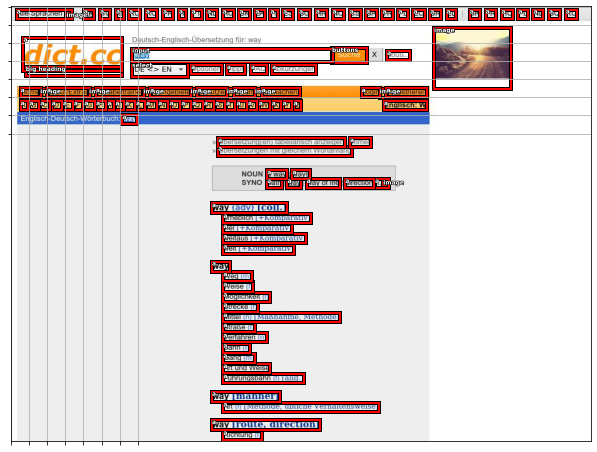

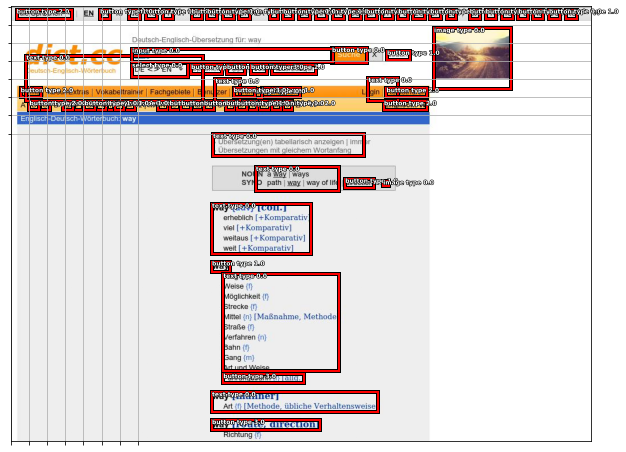

In [625]:
draw_before_after()

24952


/Users/bradleybrown/Desktop/COCOUI/create/lib/python3.7/site-packages/ipykernel_launcher.py:174: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


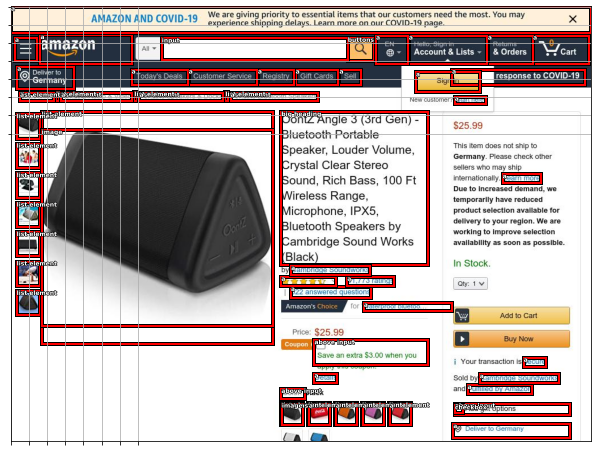

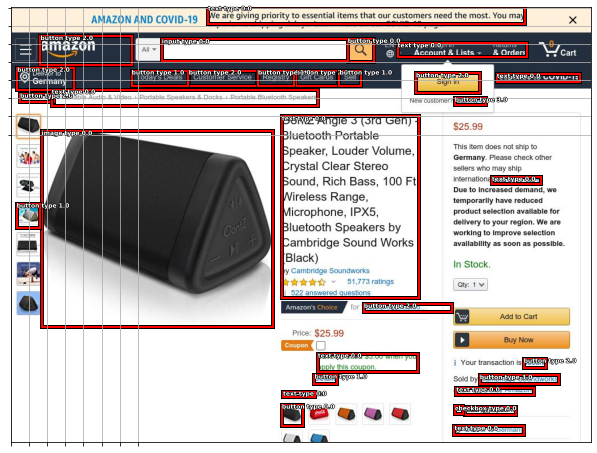

In [627]:
draw_before_after()

21932


/Users/bradleybrown/Desktop/COCOUI/create/lib/python3.7/site-packages/ipykernel_launcher.py:174: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/Users/bradleybrown/Desktop/COCOUI/create/lib/python3.7/site-packages/ipykernel_launcher.py:145: RuntimeWarning: invalid value encountered in true_divide
/Users/bradleybrown/Desktop/COCOUI/create/lib/python3.7/site-packages/ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in greater


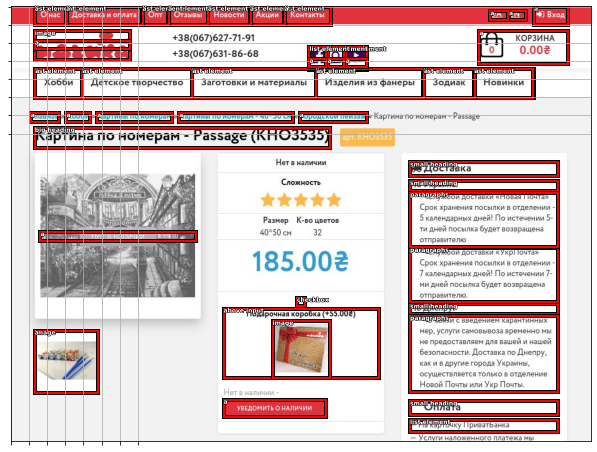

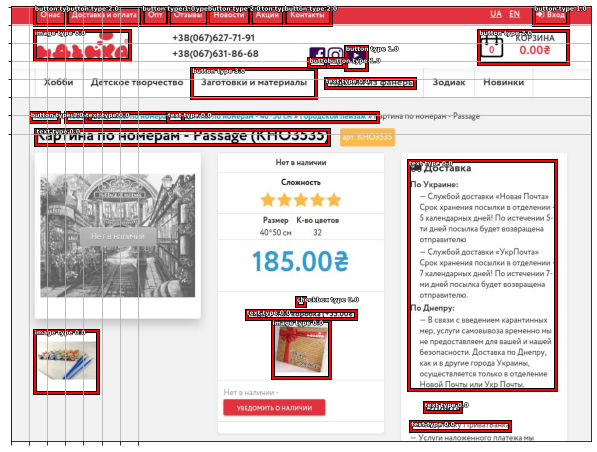

In [628]:
draw_before_after()

13151


/Users/bradleybrown/Desktop/COCOUI/create/lib/python3.7/site-packages/ipykernel_launcher.py:174: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


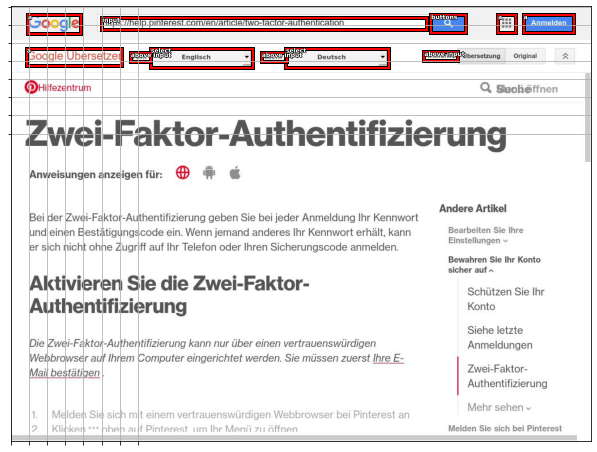

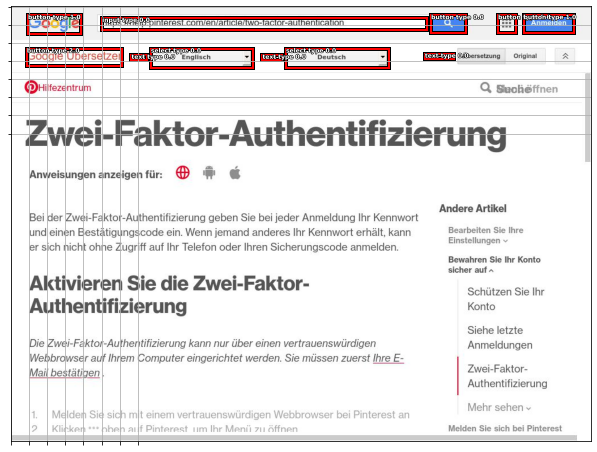

In [631]:
draw_before_after()

9738


/Users/bradleybrown/Desktop/COCOUI/create/lib/python3.7/site-packages/ipykernel_launcher.py:174: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


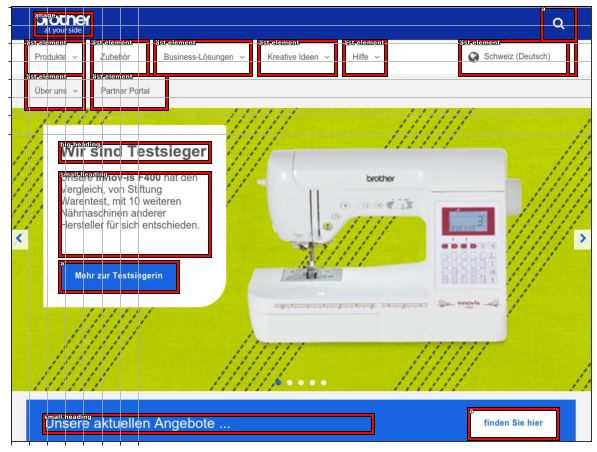

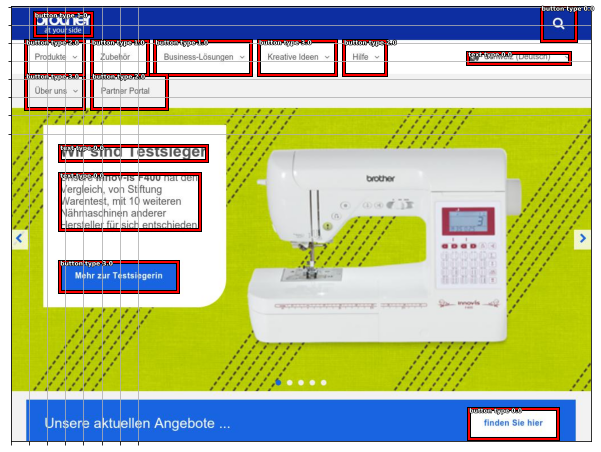

In [632]:
draw_before_after()

17913


/Users/bradleybrown/Desktop/COCOUI/create/lib/python3.7/site-packages/ipykernel_launcher.py:174: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


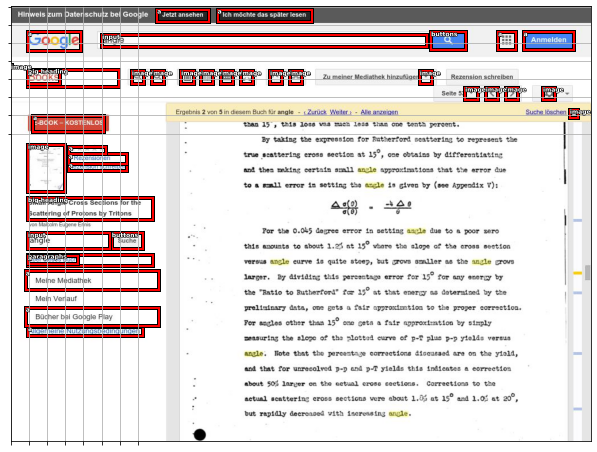

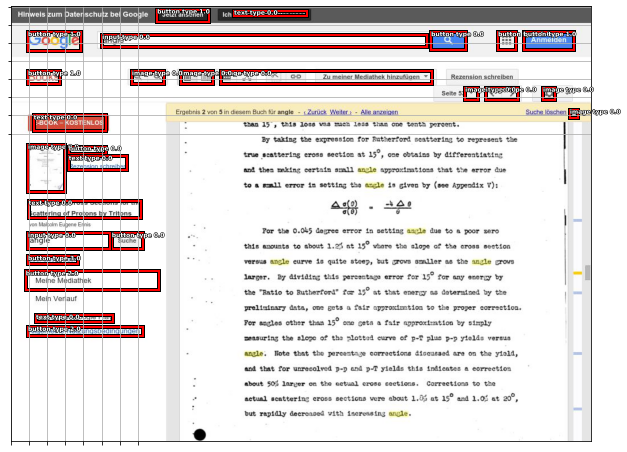

In [633]:
draw_before_after()

31943


/Users/bradleybrown/Desktop/COCOUI/create/lib/python3.7/site-packages/ipykernel_launcher.py:174: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


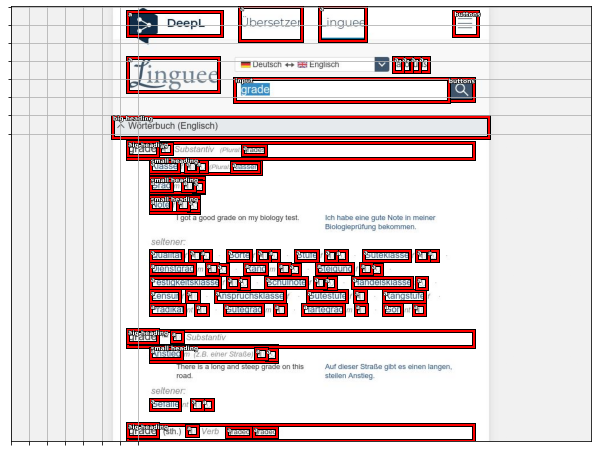

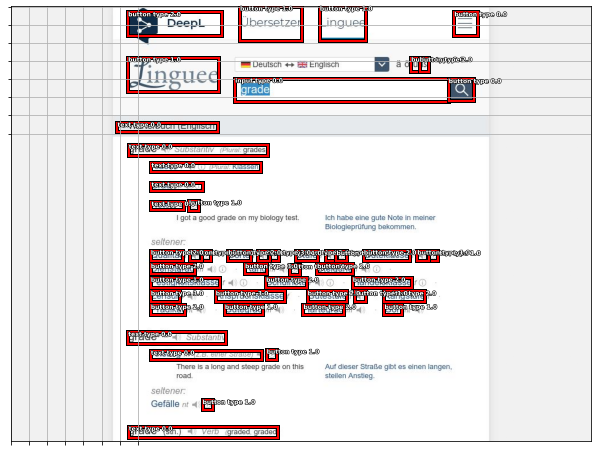

In [634]:
draw_before_after()